<a href="https://colab.research.google.com/github/187ram/Dog-Breed-Identification-CNN/blob/dev-branch/Dog_Breed_Identification_(Kaggle)_Using_Pretrained_ResNet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Totality Corp
## Assignment
**Part 1**

Build a dog breed image classification model with the architecture specified below.

**Dataset** - https://www.kaggle.com/c/dog-breed-identification/data


###Fetching data from kaggle 

In [1]:
# ! pip install -q kaggle

# from google.colab import files
# files.upload()

# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/

# ! chmod 600 ~/.kaggle/kaggle.json

# ! kaggle datasets download -d ram187/dog-breed-identification

In [6]:

# ! unzip /content/dog-breed-identification.zip

# Dog Breed Identification
The classifier only predict scores for these breeds : beagle, chihuahua, doberman,
french_bulldog, golden_retriever, malamute, pug, saint_bernard, scottish_deerhound,
tibetan_mastiff.

# Data Pre-Proccessing

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import os
from shutil import copyfile
import matplotlib.pyplot as plt
#%matplotlib inline

In [8]:
labels = pd.read_csv('labels.csv')
selected_breed_list = ['beagle', 'chihuahua', 'doberman','french_bulldog', 'golden_retriever', 'malamute', 
                      'pug', 'saint_bernard', 'scottish_deerhound', 'tibetan_mastiff']

labels = labels[labels['breed'].isin(selected_breed_list)]

In [9]:
labels_dict = {i:j for i,j in zip(labels['id'],labels['breed'])}
classes = set(labels_dict.values())
images = [f for f in os.listdir('train')]
print(len(images),images[0])

10222 b297a6f06bcc920e872fff4eeec4f9bf.jpg


In [10]:
temp = '.'.join((labels.loc[labels.index[840], 'id'],'jpg'))

In [11]:
new_image = []
for item in range(labels.size//2-1):
    if  '.'.join((labels.loc[labels.index[item], 'id'],'jpg')) in images:
        new_image.append('.'.join((labels.loc[labels.index[item], 'id'],'jpg')))

In [12]:
if  not os.path.exists('training_images'):
        os.makedirs('training_images')

if  not os.path.exists('validation_images'):
    os.makedirs('validation_images')

In [13]:
os.chdir('training_images')
for curClass in classes:    
    if  not os.path.exists(curClass):
        os.makedirs(curClass)
        #os.rmdir(curClass)

os.chdir('../validation_images')
for curClass in classes:    
    if  not os.path.exists(curClass):
        os.makedirs(curClass)

In [14]:
os.chdir('..')
count = 0 
destination_directory = 'training_images/'
for item in new_image:
    if count >680:
        destination_directory = 'validation_images/'
    filekey = os.path.splitext(item)[0]
    if  not os.path.exists(destination_directory+labels_dict[filekey]+'/'+item):
        copyfile('train/'+item, destination_directory+labels_dict[filekey]+'/'+item)
    #print(labels_dict[filekey])
    count +=1

# Displaying the original image of "Tibetan_Mastiff"

In [15]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

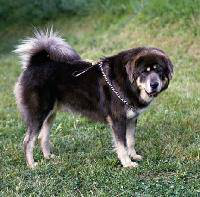

In [16]:
img = load_img('training_images/tibetan_mastiff/70fe05acafe344e3359dd4742aedbc05.jpg') 
img

##image augmentation for 3 trials of "Tibetan_Mastiff "

In [48]:
datagen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.3,
        height_shift_range=0.2,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('training_images/tibetan_mastiff/70fe05acafe344e3359dd4742aedbc05.jpg') 
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='dog_breed', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

## Displaying the image after image augmentation of "Tibetan_Mastiff "

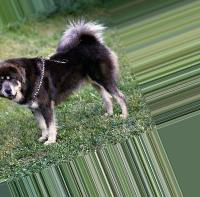

In [52]:
img1=load_img('preview/dog_breed_0_2793.jpeg')
img1

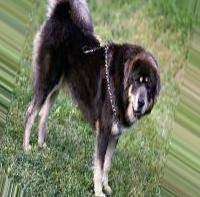

In [51]:
img2=load_img('preview/dog_breed_0_6516.jpeg')
img2

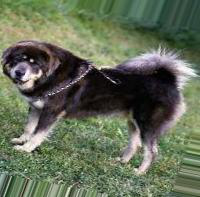

In [53]:
img3=load_img('preview/dog_breed_0_7920.jpeg')
img3

# Implementing Resnet50 Convolution Neural Network architecture.

In [55]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.utils import layer_utils
from keras import backend as K
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator

**Import ResNet50 weights trained on ImageNet**

In [56]:
#General idea: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
#The author of this article tried to classify dogs vs cats with a pretrained model and provides an abstract idea 
model = ResNet50(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

##Add 5 hidden layers and an output layer

In [57]:
x = model.output
x = Flatten()(x)
x=Dropout(0.25)(x)
# x=Dense(units=1000,activation='relu')(x)
# x=Dropout(0.25)(x)
x=Dense(units=750,activation='relu')(x)
x=Dropout(0.25)(x)
x=Dense(units=750,activation='relu')(x)
x=Dropout(0.25)(x)
x=Dense(units=750,activation='relu')(x)
x=Dropout(0.25)(x)
# x=Dense(units=1000,activation='relu')(x)
# x=Dropout(0.6)(x)
predictions = Dense(10, activation='softmax')(x)

In [61]:
import keras
main_model = Model(inputs=model.input, outputs=predictions)
#train only the hidden layers and output layer, donot train the resnet model
for curLayer in model.layers:
    curLayer.trainable = False

main_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
#main_model.summary()

## Image Augmentation

In [59]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)
#check class_mode in keras documentation https://keras.io/preprocessing/image/
training_set = train_datagen.flow_from_directory(
        'training_images',
        target_size=(224, 224),
        batch_size=22,
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        'validation_images',
        target_size=(224, 224),
        batch_size=22,
        class_mode='categorical')

Found 681 images belonging to 10 classes.
Found 159 images belonging to 10 classes.


## Model Fit

In [62]:
hist=main_model.fit(
        training_set,
        steps_per_epoch=31,
        epochs=40,
        validation_data=test_set,
        validation_steps=8,callbacks=callbacks_list)

Epoch 1/40
31/31 [==============================] - 16s 391ms/step - loss: 2.2938 - accuracy: 0.1458 - val_loss: 2.2912 - val_accuracy: 0.1321
Epoch 2/40
31/31 [==============================] - 10s 330ms/step - loss: 2.2805 - accuracy: 0.1517 - val_loss: 2.2926 - val_accuracy: 0.1321
Epoch 3/40
31/31 [==============================] - 10s 328ms/step - loss: 2.2795 - accuracy: 0.1636 - val_loss: 2.2941 - val_accuracy: 0.1321
Epoch 4/40
31/31 [==============================] - 10s 333ms/step - loss: 2.2895 - accuracy: 0.1449 - val_loss: 2.2921 - val_accuracy: 0.1321
Epoch 5/40
31/31 [==============================] - 10s 329ms/step - loss: 2.2852 - accuracy: 0.1450 - val_loss: 2.2927 - val_accuracy: 0.1321
Epoch 6/40
31/31 [==============================] - 10s 333ms/step - loss: 2.2935 - accuracy: 0.1302 - val_loss: 2.2944 - val_accuracy: 0.1321
Epoch 7/40
31/31 [==============================] - 11s 349ms/step - loss: 2.2757 - accuracy: 0.1725 - val_loss: 2.2931 - val_accuracy: 0.1321

In [24]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
# main_model.save('my_model.h5') 

# Obtain Predictions

In [63]:
import os
import cv2
import pandas as pd
import numpy as np
test_set = []
test_set_ids = []
for curImage in os.listdir('test'):
    test_set_ids.append(os.path.splitext(curImage)[0])
    curImage = cv2.imread('test/'+curImage)
    test_set.append(cv2.resize(curImage,(224, 224)))

In [64]:
test_set = np.array(test_set, np.float32)/255.0

In [ ]:
#test_set.shape

In [65]:
predictions= main_model.predict(test_set)

In [32]:
training_set.class_indices

{'beagle': 0,
 'chihuahua': 1,
 'doberman': 2,
 'french_bulldog': 3,
 'golden_retriever': 4,
 'malamute': 5,
 'pug': 6,
 'saint_bernard': 7,
 'scottish_deerhound': 8,
 'tibetan_mastiff': 9}

## Process the Prdictions to an Output File

In [33]:
classes= {index:breed for breed,index in training_set.class_indices.items()}
column_names = [classes[i] for i in range(10)]
column_names

['beagle',
 'chihuahua',
 'doberman',
 'french_bulldog',
 'golden_retriever',
 'malamute',
 'pug',
 'saint_bernard',
 'scottish_deerhound',
 'tibetan_mastiff']

In [66]:
predictions_df = pd.DataFrame(predictions)
predictions_df.columns = column_names
predictions_df.insert(0,'id', test_set_ids)
predictions_df.set_index('id',inplace=True)
predictions_df.head()

,beagle,chihuahua,doberman,french_bulldog,golden_retriever,malamute,pug,saint_bernard,scottish_deerhound,tibetan_mastiff
id,,,,,,,,,,
f15527e7a063275291e469b4e5db751c,0.121964,0.082844,0.092462,0.080204,0.078683,0.104389,0.108118,0.100379,0.152247,0.078711
401d01f09d7714d627a59780587bcae2,0.121964,0.082844,0.092462,0.080204,0.078683,0.104389,0.108118,0.100379,0.152247,0.078711
d2c130aadc05997eb5b685c10cf05a8b,0.121964,0.082844,0.092462,0.080204,0.078683,0.104389,0.108118,0.100379,0.152247,0.078711
c3bc90f915fe61ddaba580cf3bb7cacf,0.121964,0.082844,0.092462,0.080204,0.078683,0.104389,0.108118,0.100379,0.152247,0.078711
57fd7978f33934d09aa6609b770c10e8,0.121964,0.082844,0.092462,0.080204,0.078683,0.104389,0.108118,0.100379,0.152247,0.078711


In [81]:
predictions_df.to_csv('final_submission.csv',sep=",")

In [69]:
# print(hist.history)

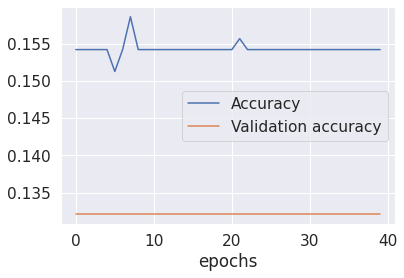

In [70]:
plt.plot(hist.history['accuracy'],label="Accuracy")
plt.plot(hist.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.xlabel('epochs')
plt.show()

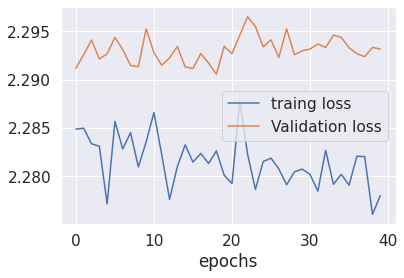

In [71]:
plt.plot(hist.history['loss'],label="traing loss")
plt.plot(hist.history['val_loss'], label="Validation loss")
plt.legend()
plt.xlabel('epochs')
plt.show()

# Evaluation metrics

In [72]:
validation_generator = test_datagen.flow_from_directory(
        'validation_images',
        target_size=(244, 244),
        batch_size=22,
        class_mode='categorical',
        shuffle=False)

Found 159 images belonging to 10 classes.


In [73]:
y_true = validation_generator.classes

Y_pred = model.predict(validation_generator, 6) #num_of_test_samples // batch_size+1
y_pred = np.argmax(np.argmax(np.argmax(Y_pred, axis = 1), axis = 1), axis=1)

print(y_true.shape,y_pred.shape)

(159,) (159,)


## Accuracy

In [74]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred)))


Accuracy: 0.07



## Confusion_matrix

In [75]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

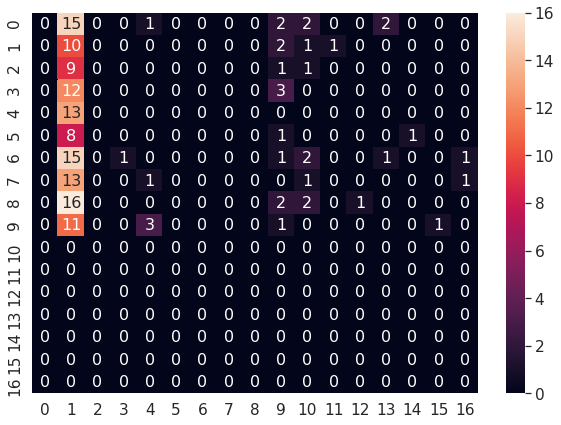

In [76]:
array = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(array, range(17), range(17))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

## F1 Score

In [77]:
print(classification_report(y_true, y_pred,))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.08      0.71      0.15        14
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        13
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        21
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00        21
           9       0.08      0.06      0.07        16
          11       0.00      0.00      0.00         0
          22       0.00      0.00      0.00         0
          24       0.00      0.00      0.00         0
          37       0.00      0.00      0.00         0
          50       0.00      0.00      0.00         0
          60       0.00      0.00      0.00         0
          65       0.00      0.00      0.00         0

    accuracy              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## ROC-AUC Score

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.datasets import load_iris

In [79]:
X, y = y_true, y_pred
X, y = load_iris(return_X_y=True)
clf = LogisticRegression(solver="liblinear").fit(X, y)
roc_auc_score(y, clf.predict_proba(X), multi_class='ovr')

0.9913333333333334

# Keras Tuner

In [ ]:
#@title
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [ ]:
#@title
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
#@title
from kerastuner.applications import HyperResNet
from kerastuner.tuners import Hyperband

hypermodel = HyperResNet(input_shape=(224, 224, 3), classes=10)

tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=40,
    directory='my_dir',
    project_name='helloworld') 

tuner.search(training_set,
            validation_data=test_set)